# AlexNet

[ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

## 요약
- ILSVRC-2012 Dataset(120만개 train data, 5만개 val data, 15만개 test data)
- Image는 256x256x3이지만 실제 input은 cropped 된 227x227x3(Augmentation)
- Batch_size 128, momentum 0.9, lr=0.0005, 90 epochs
- Weight init : zero-mean Gaussian distribution and std=0.01
- Bias init : 2,4,5의 conv layer와 FC 는 1, 나머지는 0
- 5 Conv Layer, 3 FC Layer, 3 Overlapping max pooling layer, ReLU, Cross-entropy, LRN(Local Response Normalization)
- 2 GPU 사용했지만 우리는 불가하니 1개로만 한다.<br>
(2개로 하면 각각이 다른 종류의 feature를 추출하기 때문에 성능이 더 좋아진다.)
- Translation(그냥 x,y 좌표로 움직이는거) & Horizontal reflections<br>
(256x256 -> 227x227)

연구자들이 해보니까 LRN은 별로 쓸모가 없더라, 그래서 중요하게 다루지 않는다.

github에서 여러 코드들을 보면 실제 모델의 구조와 조금 다른 부분이 많다. 우선 Convolution Layer의 channel 수가 다르고 논문에서는 2단계로 했지만 Pytorch에서는 1단계로 구현을 해 놓은 등 다양하다. 그 이유가 바로 https://arxiv.org/pdf/1404.5997v1.pdf 이놈 때문이다. 구현체에 대한 논문이 따로 있다.

<br>

구현체 논문에서의 핵심은 parallelism 테크닉을 이용하는 것이다. 근데 parallelism에도 2가지가 있는데, 하나는 Data Parallelism이고, 하나는 Model parallelism이다. 이 논문에서는 이 2가지 모두 한 번에 사용한다는 취지이다.

<br>

우선 Feature extraction에서는 Data Parallelism을 하는게 매우 효율적(시간절약) 하지만 FC 부분은 Model Parallelism을 하는 게 더 효율적

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


torch.manual_seed(40)
torch.cuda.seed()

In [170]:
def show_image(x, y, idx_to_classname=None, y_pred=None, figsize=(5,5)):
    
    x = x[:6, ...]
    y = y[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    #fig.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].permute(1,2,0))
        
        if y_pred is None:
            if idx_to_classname:
                xlabel = "True: {}".format(idx_to_classname[y[i].item()])
            else:
                xlabel = "True: {}".format(y[i])
                
        else:
            if idx_to_classname:
                xlabel = "True: {}, Pred: {}".format(idx_to_classname(y[i].item()), idx_to_classname(y_pred[i].item()))
            else:
                xlabel = "True: {}, Pred: {}".format(y[i], y_pred[i])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()
    
    plt.show()

# Data Pre-processing

In [171]:
RANDOM_SEED = 40
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### DataLoader
- ILSVRC-2012 Dataset(120만개 train data, 5만개 val data, 15만개 test data)
- Image는 256x256x3이지만 실제 input은 cropped 된 227x227x3(Augmentation)
- Translation(그냥 x,y 좌표로 움직이는거) & Horizontal reflections<br>
(256x256 -> 227x227)

In [172]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((227, 227)),
    transforms.ToTensor()
])

train_path = r'D:\data\ILSVRC2012_img_train'
val_path = r'D:\data\ILSVRC2012_img_val'

trainset = ImageFolder(root=train_path, transform=transform)
valset = ImageFolder(root=val_path, transform=transform)

train_loader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=TEST_BATCH_SIZE, shuffle=False)

print(trainset)
print('='*100)
print(valset)

Dataset ImageFolder
    Number of datapoints: 1281167
    Root location: D:\data\ILSVRC2012_img_train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(227, 227), padding=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 50000
    Root location: D:\data\ILSVRC2012_img_val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(227, 227), padding=None)
               ToTensor()
           )


### Visualization

Shape of Image :  torch.Size([16, 3, 227, 227])
Train Image


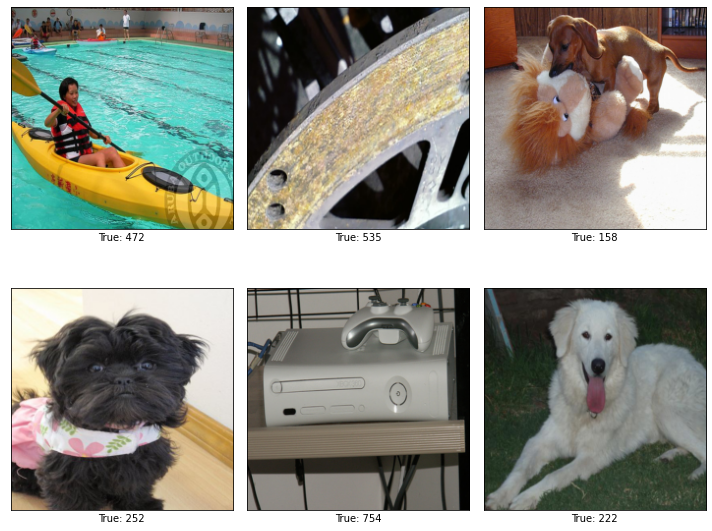

Val Image


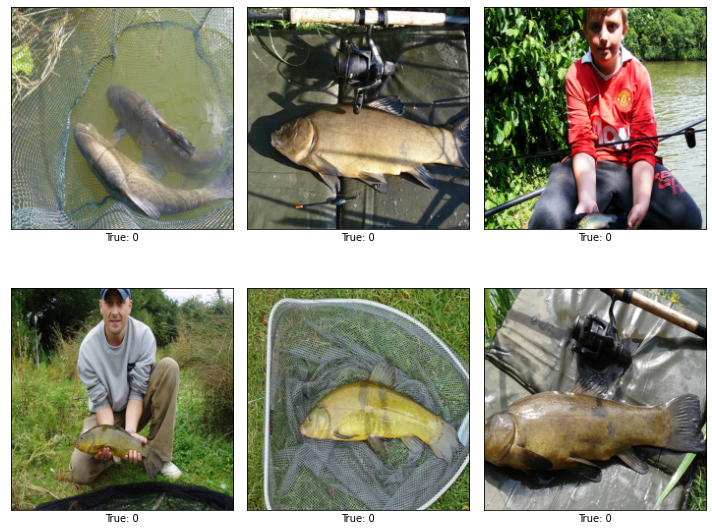

In [173]:
images, labels = iter(train_loader).next()
images_val, labels_val = iter(val_loader).next()

print("Shape of Image : ", images.shape)
print('Train Image')
show_image(images, labels, figsize=(10,10))
print('='*100)
print('Val Image')
show_image(images_val, labels_val, figsize=(10,10))

### Class name
- map_clsloc.txt : filename $\quad$ i $\quad$ classname

In [174]:
filename_to_idx = {}
filename_to_classname = {}
idx_to_classname = {}

filename_to_idx = trainset.class_to_idx

# filename to classname
for r in open(r'D:\data\map_clsloc.txt').readlines():
    r_split = r.split(' ') 
    filename_to_classname[r_split[0]] = r_split[2].replace('\n', '')
    
# idx to classname
for filename, idx in filename_to_idx.items():
    idx_to_classname[idx] = filename_to_classname[filename]

print('The Number of Filename to Classname : ', len(filename_to_classname))
print('The NUmber od idx to Classname : ', len(idx_to_classname))

The Number of Filename to Classname :  1000
The NUmber od idx to Classname :  1000


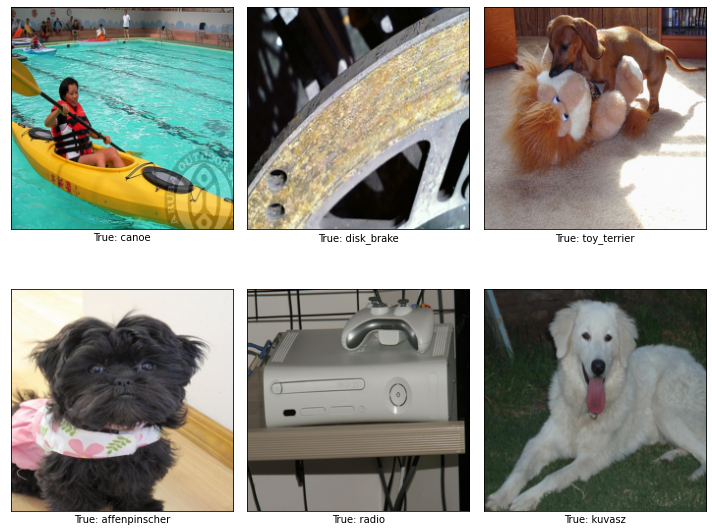

In [175]:
show_image(images, labels, idx_to_classname=idx_to_classname, figsize=(10,10))

# Model Architecture
- Batch_size 128, momentum 0.9, lr=0.0005, 90 epochs
- Weight init : zero-mean Gaussian distribution and std=0.01
- Bias init : 2,4,5의 conv layer와 FC 는 1, 나머지는 0
- 5 Conv Layer, 3 FC Layer, 3 Overlapping max pooling layer, ReLU, Cross-entropy, LRN(Local Response Normalization)
- 2 GPU 사용했지만 우리는 불가하니 1개로만 한다.<br>
(2개로 하면 각각이 다른 종류의 feature를 추출하기 때문에 성능이 더 좋아진다.)

maxpooling은 stride=2, size=3 한다고 논문에 적혀잇음 3.4 Overlapping Pooling -> 심지어 overlapping한다네

그리고 ReLU는 모든 Convolution layer와 FC layer 뒤에 나온다

input size의 크기는 227x227이다. 원본은 256이지만 227만큼 crop해서 들어간다.<br>
논문을 보면 그림에도 224라고 되어있지만, 사실 227이 맞다.<br>
근거 중 하나가 11x11 filter를 적용하면 55가 나와야하는데, 224를 넣으면 안 나온다.(stride 4인것도 감안)

In [176]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int=1000):       
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(11,11), stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            
            nn.Conv2d(96, 256, kernel_size=(5,5), stride=1, padding=2, padding_mode='zeros'), 
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            
            nn.Conv2d(256, 384, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros'),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros'),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=(3,3), stride=1, padding=1, padding_mode='zeros'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6*6*256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 6*6*256)
        x = self.classifier(x)
        
        return x

In [177]:
model = AlexNet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fa

# weight initialization
- Weight init : zero-mean Gaussian distribution and std=0.01
- Bias init : 2,4,5의 conv layer와 FC 는 1, 나머지는 0

In [178]:
# Features
for idx, layer in enumerate(model.features):
    if type(layer) == nn.Conv2d:
        # weight
        torch.nn.init.normal_(layer.weight, mean=0, std=0.01)
        
        # Bias
        if (idx+1) in [2,4,5]:
            torch.nn.init.ones_(layer.bias) 
        else:
            torch.nn.init.zeros_(layer.bias)
            
# Classifier
for idx, layer in enumerate(model.classifier):
    if type(layer) == nn.Linear:
        torch.nn.init.normal_(layer.weight, mean=0, std=0.01) # weight
        torch.nn.init.ones_(layer.bias) # bias

# optimizer & Loss Function
- Stochastic Gradient Descent(SGD) 사용
- Learning Rate : 0.01
- momentum : 0.9
- weight decay(L2 정규화) : 0.0005

In [179]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Cuda

In [180]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [ ]:
train_loss_list, val_loss_list = [], []

for e in range(EPOCHS):
    # Train
    train_loss = 0
    train_correct = 0
    
    model.to(DEVICE)
    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        train_loss += loss.cpu().item()
        
        optimizer.step()
        
        pred = output.argmax(1)
        train_correct += (pred == labels).cpu().sum().item()
        
    train_acc = train_correct / len(train_dataset)
    train_loss = train_loss / len(train_dataset)
    train_loss_list.append(train_loss)
    
    # Validation
    val_loss = 0
    val_correct = 0
    
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            output = model(images)
            loss = loss_func(output, labels)
            val_loss += loss.cpu().item()
            
            val_pred = output.argmax(1)
            val_correct += (val_pred == labels).cpu().sum().item()
            
        val_acc = val_correct / len(val_dataset)
        val_loss = val_loss / len(val_dataset)
        val_loss_list.append(val_loss)
    
    info = '[EPOCH {}/{}] : train-loss = {:0.4f} | train-acc = {:0.4f} | val-loss = {:0.4f} | val-acc = {:0.4f}'
    print(info.format(e+1, EPOCH, train_loss, train_acc, val_loss, val_acc))
    
    torch.save(model.state_dict(), 'weight')

# Test

In [ ]:
model.cpu()
model.eval()

test_correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        prediction = model(images)
        test_correct += (prediction.argmax(1) == labels).sum().item()
        
    test_acc = test_correct / len(test_dataset)
    print('Accuracy of Test Data : %0.2f%%' %(test_acc*100))

plt.plot(train_loss_list)
plt.plot(val_loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train-loss', 'Val-loss'])

plt.show()